# Few Shot Learning- Meta Learning

**Notebook內容：**
1. 資料探索與資料讀取
2. 模型訓練
3. 預測&評估
4. 練習
5. 參考資料(連結+連結說明)

延續上一份教材，我們已經之知道Few shot learning的model有哪些，那這邊我沒會把model與配合的訓練框架組裝起來

## 1.資料探索與資料讀取

In [1]:
# Download model_tools
!git clone https://github.com/DeepStudio-TW/small-data-ssl-lecture.git
!cd small-data-ssl-lecture

fatal: destination path 'small-data-ssl-lecture' already exists and is not an empty directory.


In [5]:
# 升級 gdown 套件
!pip install -q --upgrade gdown
# Download dataset
!gdown -q  https://drive.google.com/uc?id=1XagZtTeUhFWiXvlZabja0XJhBMwQFl6j&export=download
# Unzip the files
!tar zxf  mnistm_half.tar.gz

### 1.1 範例內容
* 資料來源: 
    * Source: [MNIST](http://yann.lecun.com/exdb/mnist/) 0~9 數字圖片資料
    * Target: [MNIST-M](https://paperswithcode.com/dataset/mnist-m) 0~9 數字圖片混入BSDS500照片資料庫背景

* Label: 
    * Source data label 0~9
    * target data 不使用label訓練，純粹驗證用

In [2]:
# 讀取基本套件
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
# Backend: pytorch
import torch

In [3]:
# 設一個 show data和label的function
def show_data(imgs, titles,cmap=None):
    # imshow, 縮放模式為nearest。
    plt.figure(figsize=(18, 18))
    for id,(img,title) in enumerate(zip(imgs,titles)):
        plt.subplot(1, len(titles), id+1)
        fig = plt.imshow(img,interpolation='nearest',cmap=cmap)
        plt.axis("off")
        plt.title(title)

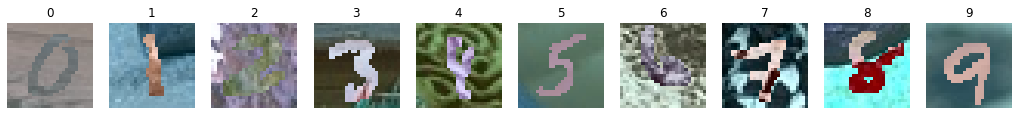

In [4]:
# 看source data: 
titles = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
example_files=[glob(f"mnistm_half/mnist_m_test/{i}/*.png")[0] for i in titles]
show_data([*map(plt.imread,example_files)],titles)

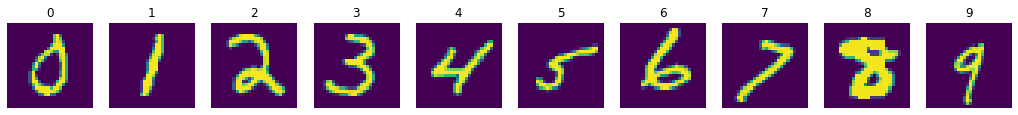

In [5]:
# 看target data
example_files=[glob(f"mnistm_half/mnist_train/{i}/*.png")[0] for i in titles]
show_data([*map(plt.imread,example_files)],titles)

### 1.2 Data Loader設計
這邊我們三個loader
* source: 來源資料集，有MNIST圖片，也有對應的label
* target: 目標資料集，只有少量MNIST-M 圖片，也有對應的label
* test: 測試資料集，有MNIST-M圖片，也有對應的label

Data Loader的要件:
* dataset: torchvision的VisionDataset，我們這邊使用ImageFolder作，只要把圖片依照分類放進資料夾就能依照資料夾名稱指定分類：
```
data_root
|--class 1
|   |--image 1
|   |--image 2
|   ...
|--class 2
|   |--image 3
...
```
* transform: augmentation function，這邊使用torchvision.transforms來做，也推薦[cv2 wrapaffine](https://theailearner.com/tag/cv2-warpaffine/)或者[aubmentation](https://github.com/albumentations-team/albumentations)，因為這是Deep Learning CV的基本所以這邊不多贅述。

* Transfer Learning Methods用的Loader:

In [6]:
import torchvision.transforms as tvt
import torchvision.datasets as tvds
from torch.utils import data as tud

train_transform = tvt.Compose([
    # 旋轉15度內 (Augmentation)，旋轉後空的地方補0
    tvt.RandomRotation(15, fill=(0,0,0)),
    # 最後轉成Tensor供model使用。
    tvt.ToTensor(),
])
test_transform = tvt.Compose([
    tvt.ToTensor(),
])

# Source套用source的transform
source_dataset = tvds.ImageFolder('mnistm_half/mnist_m_train', transform=train_transform)
# Target套用target的transform
target_dataset = tvds.ImageFolder('mnistm_half/mnist_train', transform=train_transform)
# Testing與Target那邊一樣資料，但會把label拿起來算準確度
test_dataset = tvds.ImageFolder('mnistm_half/mnist_test', transform=test_transform)

In [10]:
class MetaLearningDataset(tud.IterableDataset):
    def __init__(self,data_source,classes,ways,shots,repeats=20):
        super().__init__()
        self.data_source=data_source
        self.classes=classes
        self.ways=ways
        self.shots=shots
        self.repeats=repeats
        self.class_sample_list=[*map(self.get_subset,classes)]
        self.class_sample_len=[len(x) for x in self.class_sample_list]
    def get_subset(self,c):
        indices=[ii for ii,(_,y) in enumerate(self.data_source.samples) if y==self.data_source.class_to_idx[c]]
        return indices

    def __iter__(self):
        for _ in range(self.repeats):
            #先決定好task抽取順序
            order=np.random.permutation(len(self.class_sample_list))
            #再決定好每個task的y，數字在0~WAYS-1 之間
            idxs=[np.random.choice(range(self.ways), size=1, replace=False)[0] for _ in range(len(self.class_sample_list)//self.ways)]
            for task in range(len(self.class_sample_list)//self.ways):
                picked=[self.class_sample_list[tt] for tt in order[self.ways*task:self.ways*(task+1)]]
                tmp=[]
                for ii,classes in enumerate(picked):
                    if ii==idxs[task]:
                        sample_id=np.random.choice(range(len(classes)),size=self.shots+1, replace=False)
                    else:
                        sample_id=np.random.choice(range(len(classes)),size=self.shots, replace=False)
                    tmp.append(torch.stack([*map(lambda id: self.data_source[classes[id]][0],sample_id)],dim=0))
                # Shuffle support
                support=torch.cat([tmp[ii][:self.shots] for ii in range(self.ways)],dim=0)
                query = tmp[idxs[task]][-1:]
                yield torch.cat([support, query], dim=0),torch.tensor(idxs[task])

In [11]:
WAYS=3
SHOTS=10
source_meta_dataset=MetaLearningDataset(source_dataset,source_dataset.classes,WAYS,SHOTS,100)

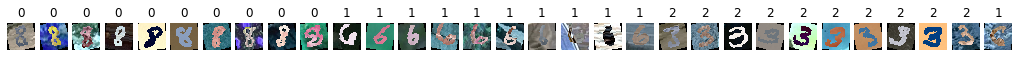

In [12]:
for x,y in source_meta_dataset:
    break
show_data(x.detach().numpy().transpose(0,2,3,1),list(np.repeat(range(WAYS),SHOTS))+[y.detach().numpy()])

* dataloader: torch 本身的dataloader class，可以將上述loader的function做batching，以及安排shuffle和多線程等動作

In [13]:
# source跟target都使用小batch size
BS_TRAIN=8
BS_TEST=16
source_meta_dataloader=tud.DataLoader(source_meta_dataset, 
                    batch_size=BS_TRAIN,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=True)

## 2.模型訓練

### 2.1 Training Loss& Optimizer
可以當成一般分類問題來給訂相關loss、optimizer

**Loss function(criterion)**
* CCE: nn.CrossEntropyLoss給label predictor output用
* BCE: nn.BCEWithLogitsLoss給domain classifier output用

In [15]:
from torch import nn
from supp.nn_model import (FeatureExtractor,PrototypicalNet,cosine,
                    FocalLoss,AddMarginLoss,ArcMarginLoss)
#@title Hyper Parameters
#@markdown Latent space dimension
latent_dims=16 #@param
#@markdown Model (meta learning): Prototypical Netwrok
backbone=FeatureExtractor(latent_features=latent_dims)
model=PrototypicalNet(WAYS,SHOTS,backbone,cosine).cuda()

#@markdown Loss (transfer learning): export criterion=LossClass(*args)
loss_type="addmargin" #@param ["cce","focal","addmargin","arcmargin"]
if loss_type=="cce":
    criterion = nn.CrossEntropyLoss()
elif loss_type=="focal":
    criterion = FocalLoss(gamma=2)
elif loss_type=="addmargin":
    criterion = AddMarginLoss(s=15.0, m=0.40,ways=WAYS,loss_fn=FocalLoss())
elif loss_type=="arcmargin":
    criterion = ArcMarginLoss(s=32.0, m=0.40,ways=WAYS, easy_margin=False,loss_fn=FocalLoss())
else:
    print("unrecognizable loss")

**Optimizer**
* 這邊使用Adam來作optimization，且三個子模型要分開，因為每個訓練step會有兩個部分:
    * 訓練domain classifier
    * 訓練label predictor+feature extractor

In [16]:
import torch.optim as optim
# 為了方便我們令一個class可以直接把dictionary key變成其attribute (可以直接用d.key)
lr=0.001
optimizer=optim.Adam(model.parameters(),lr=lr)

若有調整model可以看一下summary確定axis數、每個axis維度是否如預期

In [17]:
# from torchsummary import summary
# summary(feature_extractor, (3, 224, 224))
# summary(label_predictor, (3, 224, 224))
# summary(domain_classifier, (3, 224, 224))

### 2.2 Training Parameters& Callbacks

**Parameters**
- EPOCHS: 先設一個很大的數，當訓練不下去時也可以手動停止

- INNER_LOOPS: 每個meta batch可以多train幾次，增加強度

**Callbacks**
- Learning rate scheduling: ReduceLROnPlateau-模型訓練不下去時learning rate減少


In [18]:
EPOCHS=15
INNER_LOOPS=3
# For scheduler
# scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

### 2.3 Source data Training

In [19]:
from tqdm.notebook import tqdm
def train_epoch(epoch,model,criterion,optimizer,dataloader,ismeta=True):
    running_loss = 0.0 # Feature Extrator & Label Predictor的loss
    total_hit, total_num = 0.0, 0.0 # total_hit: 計算目前對了幾筆 total_num: 目前經過了幾筆
    session=tqdm(enumerate(dataloader))
    for i, (data, label) in session:
        data = data.cuda()
        label = label.cuda()

        for _ in range(INNER_LOOPS):
            # 訓練整個model
            if ismeta:
                class_logits = model.meta_forward(data)
            else:
                class_logits=model(data)
            # loss以指定的為主
            loss = criterion(class_logits, label)
            loss.backward()
            
            optimizer.step()
            # scheduler.step(loss) # For scheduler
            optimizer.zero_grad()

        running_loss+= loss.item()
        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == label).item()
        total_num += data.shape[0]

        session.set_postfix({"epoch":epoch,"loss":loss.item(),"acc":total_hit / total_num})
    return running_loss / (i+1), total_hit / total_num

In [20]:
# 訓練 Source
try:
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(epoch,model,criterion,optimizer,source_meta_dataloader,ismeta=True)
        torch.save(model.state_dict(), f'proto_{loss_type}.bin')
except KeyboardInterrupt:
    print("KeyboardInterrupt")

0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0it [00:00, ?it/s]

## 3.預測&評估

### 3.1 Meta Test on Target Data

In [21]:
target_meta_dataset=MetaLearningDataset(test_dataset,test_dataset.classes,WAYS,SHOTS,10)
target_meta_dataloader=tud.DataLoader(target_meta_dataset, 
                    batch_size=BS_TEST,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=True)

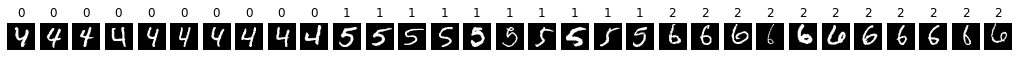

In [22]:
for x,y in target_meta_dataset:
    break
show_data(x.detach().numpy().transpose(0,2,3,1),list(np.repeat(range(WAYS),SHOTS))+[y.detach().numpy()])

In [23]:
def run_test(model,data_loader,ismeta=True):
    result = []
    total_test_hit, total_test_num = 0.0, 0.0
    with torch.no_grad():
        for i, (data,label) in enumerate(data_loader):
            test_data = data.cuda()
            test_label = label.cuda()
            
            if ismeta:
                class_logits = model.meta_forward(test_data)
            else:
                class_logits = model(test_data)
            pred = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
            result.append(pred)
            total_test_hit += torch.sum(torch.argmax(class_logits, dim=1) == test_label).item()
            total_test_num += test_data.shape[0]

    print("test acc:",total_test_hit / total_test_num)
    return result,total_test_hit / total_test_num

In [24]:
model.eval()
pred=run_test(model,target_meta_dataloader,ismeta=True)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


test acc: 0.9


### 3.2 Teting Target Task with Different N, K

In [25]:
TGT_WAYS=len(target_dataset.classes)
TGT_SHOTS=10

In [26]:
from functools import partial
from torch.utils import data as tud

class FewShotSampler(tud.Sampler):
    def __init__(self,data_source,classes,shots,repeats=100,shuffle=False):
        self.data_source=data_source
        self.classes=classes
        self.shots=shots
        self.repeats=repeats
        self.shuffle=shuffle
        
        self.class_samples=list(np.concatenate([*map(self.get_subset,classes)]))*self.repeats
    def get_subset(self,c):
        indices=np.random.permutation([ii for ii,(_,y) in enumerate(self.data_source.samples) if y==self.data_source.class_to_idx[c]])
        return indices[:self.shots]
    def __len__(self):
        return len(self.class_samples)
    def __iter__(self):
        if self.shuffle:
            np.random.shuffle(self.class_samples)
        return iter(self.class_samples)
# 每種10抽的sampler
sampler=FewShotSampler(target_dataset,classes=target_dataset.classes,shots=TGT_SHOTS,repeats=1)
# 套用至loader
target_dataloader=tud.DataLoader(target_dataset, 
                    batch_size=len(target_dataset.classes)*TGT_SHOTS,
                    shuffle=False,sampler=sampler)
#將每個class 10抽內容存起
tgt_support_x,tgt_support_y=next(iter(target_dataloader))

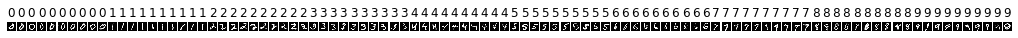

In [27]:
show_data(tgt_support_x.detach().numpy().transpose(0,2,3,1),tgt_support_y.detach().numpy())

In [28]:
# 對於待測dataset,形成loader
test_dataloader = tud.DataLoader(test_dataset,
                             batch_size=BS_TEST,
                             shuffle=False,
                             num_workers=2,
                             pin_memory=True)

In [29]:
#@title Target Model Variation
#@markdown Model (meta learning): Prototypical Netwrok
model_tgt=PrototypicalNet(TGT_WAYS,TGT_SHOTS,backbone,cosine).cuda()
#@markdown Loss (transfer learning): export criterion=LossClass(*args)
loss_type="addmargin" #@param ["cce","focal","addmargin","arcmargin"]
if loss_type=="cce":
    criterion_tgt = nn.CrossEntropyLoss()
elif loss_type=="focal":
    criterion_tgt = FocalLoss(gamma=2)
elif loss_type=="addmargin":
    criterion_tgt = AddMarginLoss(s=15.0, m=0.40,ways=TGT_WAYS,loss_fn=FocalLoss())
elif loss_type=="arcmargin":
    criterion_tgt = ArcMarginLoss(s=32.0, m=0.40,ways=TGT_WAYS, easy_margin=False,loss_fn=FocalLoss())
else:
    print("unrecognizable loss")

backbone.eval()
# 將n-way-k-shot的support data形成prototype以供inference
model_tgt.save_prototypes(tgt_support_x.cuda())
optimizer_tgt=optim.Adam(model_tgt.parameters(),lr=lr)

In [30]:
# 使用test dataloader觀察testing效果
model_tgt.eval()
pred=run_test(model_tgt,test_dataloader,ismeta=False)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


test acc: 0.7824


### 3.2 Adaptation

In [31]:
# 對於target support dataset,形成loader
sampler.shuffle=True
target_dataloader2=tud.DataLoader(target_dataset, 
                    batch_size=BS_TRAIN,
                    shuffle=False,sampler=sampler)

In [32]:
# Random Inspect parameters before fine-tuning
model_tgt.weight[0]

tensor([0.1101, 0.4606, 0.1857, 0.4765, 0.0879, 0.0000, 0.0000, 1.4872, 0.0539,
        2.1971, 0.0579, 0.0254, 1.7846, 0.0000, 0.0000, 0.2398],
       device='cuda:0', grad_fn=<SelectBackward>)

In [33]:
# 使用Target 中support set額外做adaptation
model_tgt.train()
try:
    for epoch in range(8):
        train_loss, train_acc = train_epoch(epoch,model_tgt,criterion_tgt,optimizer_tgt,target_dataloader2,ismeta=False)
        torch.save(model_tgt.state_dict(), f'proto_{loss_type}_adapted.bin')
except KeyboardInterrupt:
    print("KeyboardInterrupt")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [34]:
# Random Inspect parameters after fine-tuning
model_tgt.weight[0]

tensor([ 1.1546e-01,  4.1859e-01,  3.4937e-02,  3.8510e-01,  4.2982e-02,
        -9.6600e-02, -6.8420e-02,  1.5178e+00, -9.1063e-04,  2.2737e+00,
         3.6870e-02, -3.1410e-02,  1.7495e+00, -1.1433e-02, -2.7552e-02,
         1.4899e-01], device='cuda:0', grad_fn=<SelectBackward>)

In [35]:
# 使用test dataloader觀察testing效果
model_tgt.eval()
pred=run_test(model_tgt,test_dataloader,ismeta=False)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


test acc: 0.814


## 4.練習

1. 這次練習的是使用雜色的MNIST-M做source meta train，MNIST作為meta test，請試著把兩個資料集倒過來
2. 嘗試不同的source training組合:
    - cce & focal loss & addmargin loss & arcmargin loss
3. 嘗試不同target training組合:
    - cce & focal loss & addmargin loss & arcmargin loss
4. 將target way數, shot數改變為5way 5 shot，試著調整出最佳組合


## 5.參考資料

* [Snell, J., Swersky, K., & Zemel, R. S. (2017). Prototypical networks for few-shot learning. arXiv preprint arXiv:1703.05175.](https://arxiv.org/abs/1703.05175)
    - Prototypical networks原文
* [Lin, T. Y., Goyal, P., Girshick, R., He, K., & Dollár, P. (2017). Focal loss for dense object detection. In Proceedings of the IEEE international conference on computer vision (pp. 2980-2988). ](https://arxiv.org/abs/1708.02002v2)
    - Focal Loss原文
* [Wang, H., Wang, Y., Zhou, Z., Ji, X., Gong, D., Zhou, J., ... & Liu, W. (2018). Cosface: Large margin cosine loss for deep face recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 5265-5274).](https://arxiv.org/abs/1801.09414)
    - CosineFace原文
* [Deng, J., Guo, J., Xue, N., & Zafeiriou, S. (2019). Arcface: Additive angular margin loss for deep face recognition. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 4690-4699).](https://arxiv.org/abs/1801.07698)
    - ArcFace原文